# Volatility Models - Project
Cojutti Francesco - Khalil Hassan - Ngoc Truong Nguyen

#4) Options on VIX

In [ ]:
# Import the necessary package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

In [ ]:
!pip install py_vollib
import py_vollib.black_scholes.implied_volatility as bs_iv

#### The Heston Call Pricer is build in three steps:


1.   **Step 1:** **implement the characteristic function :**
$\varphi(X_0, K, v_0,\tau; \phi) = e^{r \phi i \tau} S^{i \phi}[\frac{1-ge^{d\tau}}{1-g}]^{\frac{-2a}{\sigma^2}} exp[\frac{a \tau}{\sigma^2} (b_2 -\rho\sigma \phi i + d) + \frac{v_0}{\sigma^2}(b_2 -\rho\sigma \phi i + d)[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]]$

Where:


*   $d = \sqrt{(\rho\sigma \phi i – b)^2 + \sigma^2 (\phi i + \phi^2)}$
*   $g = \frac{b -\rho\sigma \phi i + d}{b -\rho\sigma \phi i – d}$
*   $a = \kappa \theta$
*   $b = \kappa + \lambda$



2.   **Step 2: Definition of the integrand :**
$\int_{0}^{\infty} \Re \left( e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} – K\frac{\varphi(\phi)}{i\phi K^{i\phi}} \right) d\phi$



3. **Step 3: Numerical integration over integrand and option price calculation:**
$C(S_0, K, v_0, \tau) = \frac{1}{2}(S_0 – Ke^{-r \tau}) + \frac{1}{\pi} \int_{0}^{\infty} \Re \left( e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} – K\frac{\varphi(\phi)}{i\phi K^{i\phi}} \right) d\phi$



In [ ]:
import numpy as np
from scipy.integrate import quad

class HestonOptionPricer:
    def __init__(self, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
        self.S0 = S0              # Initial stock price
        self.v0 = v0              # Initial volatility
        self.kappa = kappa        # Mean reversion rate
        self.theta = theta        # Long run variance
        self.sigma = sigma        # Volatility of variance
        self.rho = rho            # Correlation parameter
        self.lambd = lambd        # Variance risk premium
        self.tau = tau            # Time to Maturity
        self.r = r                # Interest Rate

    # Implementation of the characteristic function
    def heston_charfunc(self, phi):
        # constants
        a = self.kappa * self.theta
        b = self.kappa + self.lambd

        # common terms w.r.t phi
        rspi = self.rho * self.sigma * phi * 1j

        # define d parameter given phi and b
        d = np.sqrt((self.rho * self.sigma * phi * 1j - b)**2 + (phi * 1j + phi**2) * self.sigma**2)

        # define g parameter given phi, b and d
        g = (b - rspi + d) / (b - rspi - d)

        # calculate characteristic function by components
        exp1 = np.exp(self.r * phi * 1j * self.tau)
        term2 = self.S0**(phi * 1j) * ((1 - g * np.exp(d * self.tau)) / (1 - g))**(-2 * a / self.sigma**2)
        exp2 = np.exp(a * self.tau * (b - rspi + d) / self.sigma**2 + self.v0 * (b - rspi + d) * ((1 - np.exp(d * self.tau)) / (1 - g * np.exp(d * self.tau))) / self.sigma**2)

        return exp1 * term2 * exp2

    # Definition of the integrand
    def integrand(self, phi, K):
        numerator = np.exp(self.r * self.tau) * self.heston_charfunc(phi - 1j) - K * self.heston_charfunc(phi)
        denominator = 1j * phi * K**(1j * phi)
        return numerator / denominator

    # Numerical integration over integrand and option price calculation
    def heston_price(self, K):
        real_integral, _ = np.real(quad(self.integrand, 0, 1000, args=(K,)))
        return max(0, (self.S0 - K * np.exp(-self.r * self.tau)) / 2 + real_integral / np.pi)

In [ ]:
# Example usage:
initial_VIX = 15       # It indicates that the implied volatility of 30-day options on the S&P 500 is estimated as 15%.
strike_VIX = 10
v0 = 0.04
kappa = 1.5
theta = 0.04
sigma = 0.3
rho = -0.5
lambd = 0.5
tau = 1
r = 0.05

option_pricer = HestonOptionPricer(initial_VIX, v0, kappa, theta, sigma, rho, lambd, tau, r)
option_price = option_pricer.heston_price(strike_VIX)
print("the Call Price using Heston model is equal to:", round(option_price,3))

the Call Price using Heston model is equal to: 6.049


# VIX options volatility smiles using the classical Heston model

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


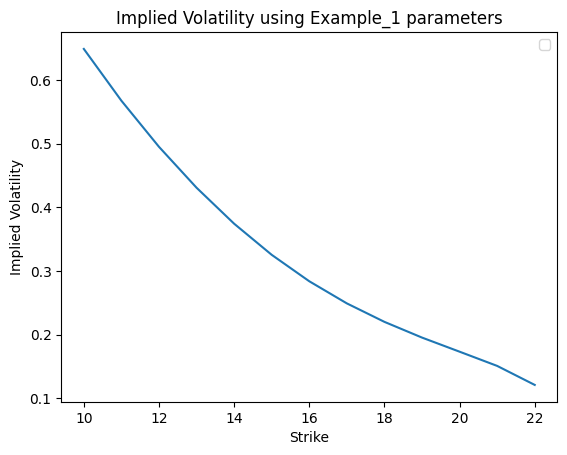

In [ ]:
# Parameters
initial_VIX = 18
v0 = 0.04
kappa = 1.5
theta = 0.04
sigma = 0.3
rho = -0.5
lambd = 0.5
tau = 1
r = 0.05

# For the strikes if the value is >23 we get the error that "the volatility is below the intrinsic value"
# Because the parameters of the model are not calibrated on the market data.

K = [k for k in range(10, 23)]
implied_vol = []
option_pricer = HestonOptionPricer(initial_VIX, v0, kappa, theta, sigma, rho, lambd, tau, r)
for strike in K:
    call_price = option_pricer.heston_price(strike)
    # Here we derived implied volatility using built-in pyvolib package
    vol = bs_iv.implied_volatility(call_price, initial_VIX, strike ,tau, r, flag='c')
    implied_vol.append(vol)

plt.plot(K, implied_vol)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title("Implied Volatility using Example_1 parameters")
plt.legend()

# Model Calibration (Extension)

### 1) Market Data Extraction and Preprocessing

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Fetch VIX data
vix = yf.Ticker("^VIX")

# Last VIX traded value
S0 = vix.history(period="1d")['Close'].iloc[0]

market_prices = {}

# Create a dictionnary that contains the maturities as keys and the different
# strikes and prices as values (the lists of strikes and prices are grouped in a dictionnary)
for maturity in list(vix.options):
  market_prices[maturity] = {}
  market_prices[maturity]['strike'] = list(vix.option_chain(maturity).calls['strike'])
  market_prices[maturity]['price'] = list((vix.option_chain(maturity).calls['bid'] + vix.option_chain(maturity).calls['ask'])/2)

# Filter the strikes that are common to all maturities
all_strikes = [v['strike'] for i,v in market_prices.items()]
common_strikes = set.intersection(*map(set,all_strikes))
print('Number of common strikes:', len(common_strikes))
common_strikes = sorted(common_strikes)

Number of common strikes: 27


In [ ]:
# Fill the prices and maturities lists with the market prices of call options
# (corresponding to the strikes common to all maturities) and the maturities.
prices = []
maturities = []
for date, v in market_prices.items():
    maturities.append((dt.strptime(date, '%Y-%m-%d') - dt(2024, 3, 31)).days/365.25)
    price = [v['price'][i] for i,x in enumerate(v['strike']) if x in common_strikes]
    prices.append(price)

# Organize the data into a dataframe
price_arr = np.array(prices, dtype=object)
np.shape(price_arr)
volSurface = pd.DataFrame(price_arr, index = maturities, columns = common_strikes)
volSurface.dropna(inplace=True)
# Filter out the maturities less than 1 day, and the market prices that are equal to 0.
volSurface = volSurface.iloc[(volSurface.index >= 1/365.25), (volSurface.columns > 0)]

# Convert our vol surface to dataframe with three columns (maturity, strike, market_price)
# for each call option
volSurfaceLong = volSurface.melt(ignore_index=False).reset_index()
volSurfaceLong.columns = ['maturity', 'strike', 'price']

 ### 2) Optimization of the Objective Function

Let $\Theta$ be the set of model parameters:

$\Theta = (v0, \kappa, \theta, \sigma, \rho, \lambda)$

The aim of the calibration is to minimize the least squared error:

**The Squared Error:**

$SqErr(\Theta) = \sum^N_{i=1}\sum^M_{j=1}w_{ij}(C_{MP}(K_i,\tau_j) – C_{SV}(S_\tau, K_i,\tau_j,r,\Theta))^2 + Penalty(\Theta, \Theta_0)$


Where $C_{MP}(K_i,\tau_j)$ denotes the market price for a call with strike $K_i$ and maturity $\tau_j$ . $C_{SV}$ is the price calculated with the Heston model which depends on the vector of model parameters $\Theta = (v0, \kappa, \theta, \sigma, \rho, \lambda)$.

The penalty function that we chosed is the distance to the initial parameter vector $Penalty(\Theta, \Theta_0) = ||\Theta − \Theta_0||^2$ and is used to give the calibration some additional stability.

The optimization of the objective function is then given by:

$\hat{\Theta} = \underset{\Theta \in U_\Theta}{arg \ min} \ SqErr(\Theta)$

With $U_\Theta$ the set of possible combinations of parameters.

In [ ]:
# Define variables to be used in optimization
S0 = vix.history(period="1d")['Close'].iloc[0]        # Last VIX traded value
r = 0.05                                              # Interest rate
K = volSurfaceLong['strike'].to_numpy('float')        # Series of the Strikes
tau = volSurfaceLong['maturity'].to_numpy('float')    # Series of time to maturities
P = volSurfaceLong['price'].to_numpy('float')         # Series of market prices

# Model parameters to calibrate (with an initial guess and there bounds)

params = {"v0": {"x0": 0.1, "lbub": [0, None]},
          "kappa": {"x0": 3, "lbub": [0, None]},
          "theta": {"x0": 0.05, "lbub": [0, None]},
          "sigma": {"x0": 0.3, "lbub": [0 , 1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          "lambd": {"x0": 0.03, "lbub": [None,None]},
          }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

# The objective function is the mean squared errors between the market prices and model prices.
def objective_function(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]
    errors = []
    for market_price, strike, T in zip(P, K, tau):
        option_pricer = HestonOptionPricer(S0, v0, kappa, theta, sigma, rho, lambd, T, r)
        call_price = option_pricer.heston_price(strike)
        errors.append((call_price - market_price)**2)

    pen = np.sum([(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )
    # pen = 0
    return sum(errors) + pen

# Function to estimate the model parameters that minimize the objective function
result = minimize(objective_function, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)

In [ ]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
print("The calibrated parameters are:")
print(f"v0: {v0}")
print(f"kappa: {round(kappa, 3)}")
print(f"theta: {round(theta, 3)}")
print(f"sigma: {round(sigma, 3)}")
print(f"rho: {round(rho, 3)}")
print(f"lambd: {round(lambd, 3)}")

The calibrated parameters are:
v0: 1.8557511536361577
kappa: 1.183
theta: 0.242
sigma: 1.0
rho: -1.0
lambd: -1.836


### Using Heston Model with the calibrated parameters to plot the Implied Volatility

<ipython-input-4-b236df0bb530>:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_integral, _ = np.real(quad(self.integrand, 0, 1000, args=(K,)))


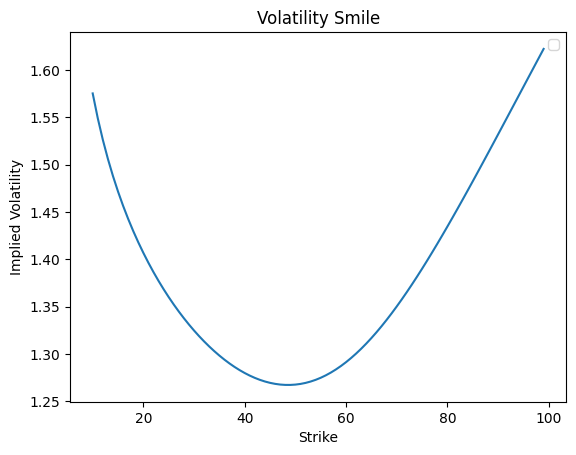

In [ ]:
initial_VIX = 15
tau = 0.5
r = 0.05
# v0, kappa, theta, sigma, rho, lambd = 0.1, 0.001, 0.1, 0.01, 0.0, -1.0
# Now using the calibrated parameters we can use strikes greater than 23 (as opposed to the previous IV curve).
K = [k for k in range(10, 100)]
implied_vol = []
option_pricer = HestonOptionPricer(initial_VIX, v0, kappa, theta, sigma, rho, lambd, tau, r)
for strike in K:
    call_price = option_pricer.heston_price(strike)
    # Here we derived implied volatility using built-in pyvolib package
    vol = bs_iv.implied_volatility(call_price, initial_VIX, strike, tau, r, flag='c')
    implied_vol.append(vol)

plt.plot(list(K), implied_vol)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title("Volatility Smile")
plt.legend()

### Comparision between the volatility smile using Heston Model with Calibrated parameters and the volatility smile implied by the market

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
<ipython-input-4-b236df0bb530>:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_integral, _ = np.real(quad(self.integrand, 0, 1000, args=(K,)))


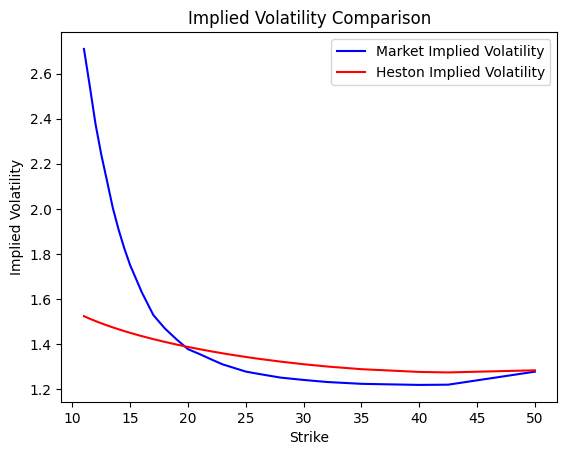

In [ ]:
tau = 199/365.25        # we choose a maturity of 199 days (the largest available maturity)
df = volSurfaceLong[volSurfaceLong["maturity"] == tau].reset_index()
r=0.05
implied_vol_market = []
implied_vol_heston = []
option_pricer = HestonOptionPricer(S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
for i, K in enumerate(df["strike"]):
  vol = bs_iv.implied_volatility(df["price"][i], S0, K, tau, r, flag='c')
  implied_vol_market.append(vol)
  call_price = option_pricer.heston_price(K)
  # Here we derived implied volatility using built-in pyvolib package
  vol = bs_iv.implied_volatility(call_price, S0, K, tau, r, flag='c')
  implied_vol_heston.append(vol)


plt.plot(list(df["strike"]), implied_vol_market, label='Market Implied Volatility', color='blue')
plt.plot(list(df["strike"]), implied_vol_heston, label='Heston Implied Volatility', color='red')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Comparison')
plt.legend()